In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
plt.style.use('dark_background')

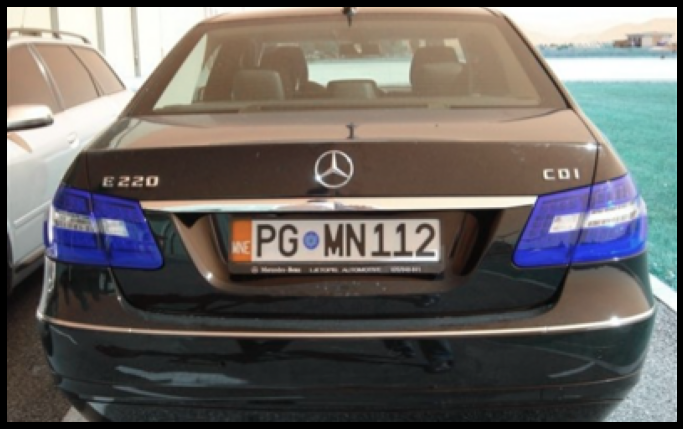

In [8]:
img_ori = cv2.imread('A:\Awiros X Intel\car-plate-detection\images\Cars1.png')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.savefig('Car.png',bbox_inches = 'tight')
plt.show()

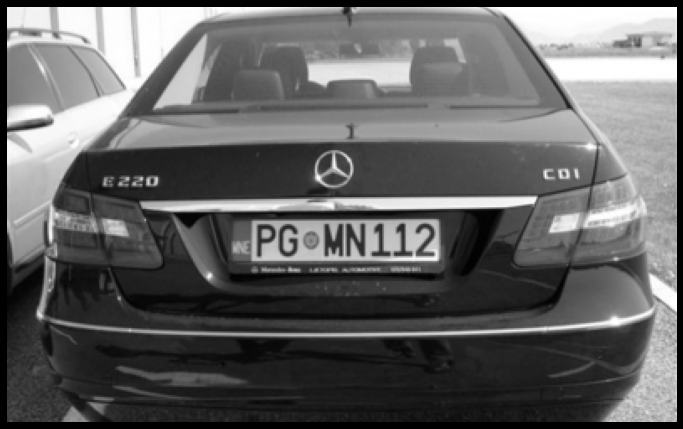

In [9]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-GrayScale.png',bbox_inches = 'tight')
plt.show()

In [10]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

In [11]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

In [12]:
contours, _= cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [13]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

In [14]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

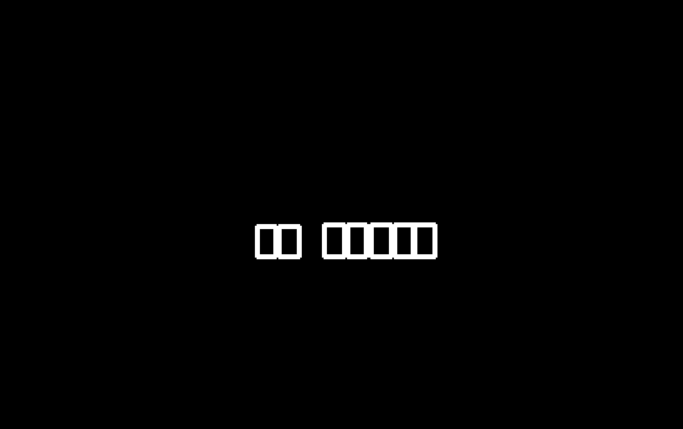

In [15]:
MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

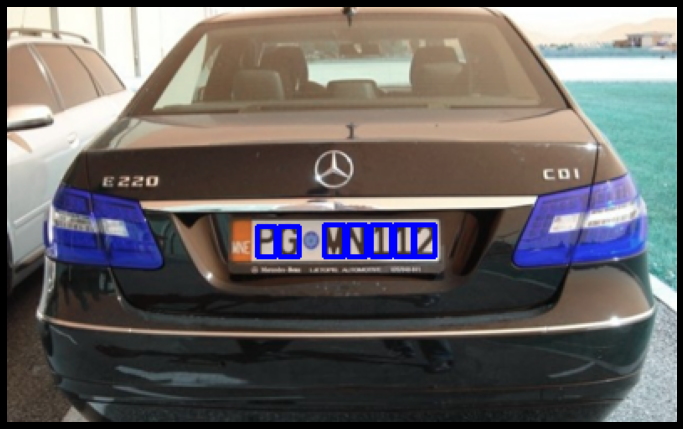

In [16]:
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(img_ori, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.savefig('Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()

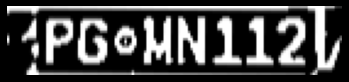

In [17]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Rotated).png',bbox_inches = 'tight')
    plt.show()

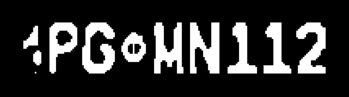

In [18]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Thresholding).png',bbox_inches = 'tight')
    plt.show()
    break

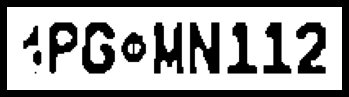

In [19]:
img = 255-img_result
plt.imshow(img, 'gray')
plt.axis('off')
plt.savefig('Car-Plates(Negative).png',bbox_inches = 'tight')
plt.show()

In [20]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.axis('off')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [21]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))

    LP_WIDTH = img_lp.shape[0]
    LP_HEIGHT = img_lp.shape[1]

    # Make borders white
    img_lp[0:3,:] = 255
    img_lp[:,0:3] = 255
    img_lp[72:75,:] = 255
    img_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_lp, cmap='gray')
    plt.axis('off')
    plt.show()
    cv2.imwrite('contour.jpg', img_lp)
    

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_lp)

    return char_list

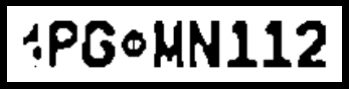

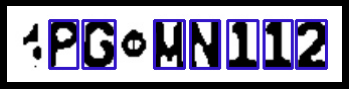

In [22]:
char = segment_characters(img)

In [23]:
plt.style.use('ggplot')

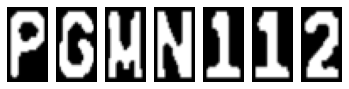

In [24]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.savefig('Car-Plates-Char(Seperated).png',bbox_inches = 'tight')

In [25]:
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from keras.models import Sequential,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K

In [26]:
! pip install --upgrade tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/27/7e/9699c0ebd2bf124df8446bc4767390c023f7bb2d072b7ff92ae7f3fc1379/tensorflow-2.14.0-cp39-cp39-win_amd64.whl.metadata
  Using cached tensorflow-2.14.0-cp39-cp39-win_amd64.whl.metadata (3.3 kB)
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/29/ab/79512973474b56a7f9efef2cab0ec2f803759e90e1b65ff0383d2b0788c4/tensorflow_intel-2.14.0-cp39-cp39-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.14.0-cp39-cp39-win_amd64.whl.metadata (4.8 kB)
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/package

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ASUS\\AppData\\Local\\Temp\\pip-uninstall-gb6f0u_i\\internal\\_api_implementation.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



  Obtaining dependency information for tensorboard<2.15,>=2.14 from https://files.pythonhosted.org/packages/73/a2/66ed644f6ed1562e0285fcd959af17670ea313c8f331c46f79ee77187eb9/tensorboard-2.14.1-py3-none-any.whl.metadata
  Using cached tensorboard-2.14.1-py3-none-any.whl.metadata (1.7 kB)
  Obtaining dependency information for tensorflow-estimator<2.15,>=2.14.0 from https://files.pythonhosted.org/packages/d1/da/4f264c196325bb6e37a6285caec5b12a03def489b57cc1fdac02bb6272cd/tensorflow_estimator-2.14.0-py2.py3-none-any.whl.metadata
  Using cached tensorflow_estimator-2.14.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Obtaining dependency information for keras<2.15,>=2.14.0 from https://files.pythonhosted.org/packages/fe/58/34d4d8f1aa11120c2d36d7ad27d0526164b1a8ae45990a2fede31d0e59bf/keras-2.14.0-py3-none-any.whl.metadata
  Using cached keras-2.14.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Obtaining dependency information for te


Using cached tensorboard_data_server-0.7.1-py3-none-any.whl (2.4 kB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6


In [28]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'A:\Awiros X Intel\data_arpl'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [29]:
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)
# initiator of the line evaluation 

In [30]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")

def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./{}.h5".format(model_name))
    return model

In [31]:
store_keras_model

<function __main__.store_keras_model(model, model_name)>

In [32]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

c:\Users\ASUS\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                        

In [34]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
              self.model.stop_training = True

In [35]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 15, verbose=1, callbacks=callbacks)

<ipython-input-35-f06c142ad977>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/15
864/864 [==============================] - 59s 67ms/step - loss: 3.3734 - custom_f1score: 0.0868 - val_loss: 2.6686 - val_custom_f1score: 0.3333
Epoch 2/15
864/864 [==============================] - 61s 70ms/step - loss: 1.8264 - custom_f1score: 0.4699 - val_loss: 1.0652 - val_custom_f1score: 0.7098
Epoch 3/15
864/864 [==============================] - 66s 77ms/step - loss: 0.9174 - custom_f1score: 0.7106 - val_loss: 0.5788 - val_custom_f1score: 0.8185
Epoch 4/15
864/864 [==============================] - 75s 86ms/step - loss: 0.5073 - custom_f1score: 0.8403 - val_loss: 0.4379 - val_custom_f1score: 0.8676
Epoch 5/15
864/864 [==============================] - 63s 73ms/step - loss: 0.3414 - custom_f1score: 0.8947 - val_loss: 0.1894 - val_custom_f1score: 0.9494
Epoch 6/15
864/864 [==============================] - 64s 75ms/step - loss: 0.2690 - custom_f1score: 0.9074 - val_loss: 0.3071 - val_custom_f1score: 0.9018
Epoch 7/15
864/864 [==============================] - 63s 73ms/s

In [36]:
store_keras_model(model, 'model_LicensePlate')

Saved model to disk


In [37]:
pre_trained_model = load_keras_model('model_LicensePlate')
model = pre_trained_model 

In [38]:
print(pre_trained_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                        

In [39]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img 
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_pred = model.predict(img)
        y_ = np.argmax(y_pred, axis=-1)[0]
 #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1/1 [==============================] - 0s 34ms/step
PGMN112


1/1 [==============================] - 0s 36ms/step
PGMN112
1/1 [==============================] - 0s 38ms/step


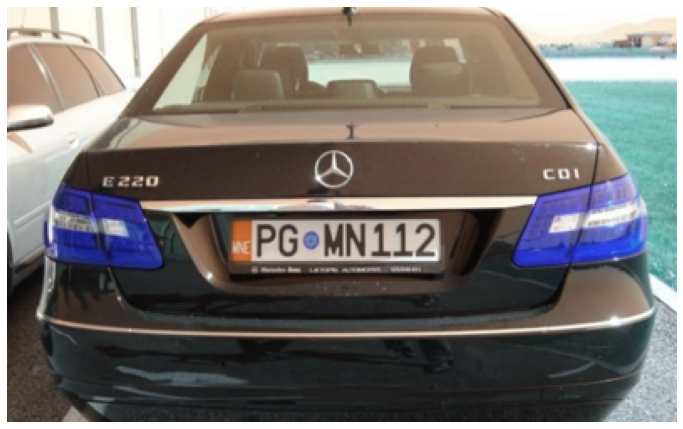

In [41]:
import json

def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img 
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_pred = model.predict(img)
        y_ = np.argmax(y_pred, axis=-1)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())
# ... (your code for fix_dimension, show_results, and other setup) ...

def save_results_as_json():
    plate_number = show_results()
    result_dict = {'plate_number': plate_number}

    # Save the result to a JSON file
    with open('plate_number.json', 'w') as json_file:
        json.dump(result_dict, json_file)

save_results_as_json()
img_ori = cv2.imread('A:\Awiros X Intel\car-plate-detection\images\Cars1.png')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.savefig('Car.png',bbox_inches = 'tight')
plt.show()

In [42]:
pip install --upgrade keras

  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/fe/58/34d4d8f1aa11120c2d36d7ad27d0526164b1a8ae45990a2fede31d0e59bf/keras-2.14.0-py3-none-any.whl.metadata
  Using cached keras-2.14.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.14.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.1 requires keras<2.11,>=2.10.0, but you have keras 2.14.0 which is incompatible.
tensorflow 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.10.1 requires tensorflow-estimator<2.11,>=2.10.0, but you have tensorflow-estimator 2.14.0 which is incompatible.
tensorflow-intel 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.14.0 which is incompatible.
tensorflow-intel 2.13.0 requires tensorboard<2.14,>=2.13, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.13.0 requires tensorflow-estimator<2.14,>=2.13.0, but you have tensorflow-estimator 2.14.0 which is incompatible.


1/1 [==============================] - 0s 37ms/step


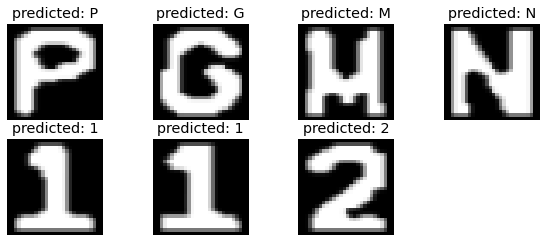

In [43]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    title_obj = plt.title(f'predicted: {show_results()[i]}')
    plt.setp(title_obj, color='black')
    plt.axis('off')
plt.show()